In [ ]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('Supermarket_Sweep.csv')

In [ ]:
def shortest_item_to_item(item1x, item1y, item2x, item2y):
    if (item1x == item2x):
        return abs(item1y - item2y)
    else:
        return min((item1y + item2y), (220 - item1y - item2y)) + abs(item1x - item2x)

In [ ]:
def shortest_start_to_item(itemx, itemy):
    if (itemx == 0):
        return itemy
    else:
        return itemx + itemy

In [ ]:
df.loc[57] = ['End Node', 0.0, 0, 0]

shortest_item_to_item_dict = {}
shortest_start_to_item_dict = {}
price_dict ={}
item_list = []

for i in df.index:
    for j in df.index:
        shortest_item_to_item_dict[df["Item "][i], df["Item "][j]] = shortest_item_to_item(df["X Position"][i], df["Y Position"][i], df["X Position"][j], df["Y Position"][j])/10

for i in df.index:
    shortest_start_to_item_dict[df["Item "][i]] = shortest_start_to_item(df["X Position"][i], df["Y Position"][i])/10

for i in df.index:
    price_dict[df["Item "][i]] = df["Price"][i]

for i in df.index:
    item_list.append(df["Item "][i])

In [ ]:
def write_to_csv():
    df_shortest_item_to_item = pd.DataFrame(shortest_item_to_item_dict.items(), columns=['Item to Item', 'Duration'])
    df_shortest_start_to_item = pd.DataFrame(shortest_start_to_item_dict.items(), columns=['Start to Item', 'Duration'])
    df_shortest_item_to_item.to_csv("item_to_item.csv")
    df_shortest_start_to_item.to_csv("start_to_item.csv")

    return

In [ ]:
write_to_csv()

In [ ]:
def part_c(max_time):

    m = Model("Supermarket Sweep")

    x = {}
    z = {}

    # x variables
    for i in range(0, 57):
        for j in range(1, 58):
            for k in range(1, 3):
                x[i, j, k] = m.addVar(vtype = GRB.BINARY, name = f'x_{i}_{j}_{k}')

    # z variables
    for i in range(1, 57):
        for k in range(1, 3):
            z[i, k] = m.addVar(vtype = GRB.BINARY, name = f'z_{i}_{k}')

    m.addConstr(x[0, 57, 1] == 0)
    m.addConstr(x[0, 57, 2] == 0)

    # Ensure no subtours
    for i in range(0, 57):
        for j in range(1, 58):
            for k in range(1, 3):
                if (i >= j):
                     m.addConstr(x[i, j, k] == 0)

    # 10 items max for each shopper
    m.addConstr(quicksum(z[i, 1] for i in range(1, 57)) <= 10)
    m.addConstr(quicksum(z[i, 2] for i in range(1, 57)) <= 10)

    # Each item can be grabbed once by either shoppers
    for i in range(1, 57):
        m.addConstr(quicksum(z[i,k] for k in range(1, 3)) <= 1)

    # 60 seconds max for each shopper
    for k in range(1, 3):
        m.addConstr((quicksum(shortest_item_to_item_dict[item_list[i], item_list[j]]*x[i, j, k] for i in range(0, 57) for j in range(1, 58)) + 2 * quicksum(z[i,k] for i in range(1, 57))) <= max_time)

    # Connectivity constraints between zik and xijk
    for j in range(1, 57):
        m.addConstr(quicksum(x[i, j, 1] for i in range(0, 57)) == z[j, 1])
        m.addConstr(quicksum(x[i, j, 2] for i in range(0, 57)) == z[j, 2])

    for i in range(1, 57):
        m.addConstr(quicksum(x[i, j, 1] for j in range(1, 58)) == z[i, 1])
        m.addConstr(quicksum(x[i, j, 2] for j in range(1, 58)) == z[i, 2])

    # Shopper must reach end node
    m.addConstr(quicksum(x[i, 57, 1] for i in range(1, 57)) == 1)
    m.addConstr(quicksum(x[i, 57, 2] for i in range(1, 57)) == 1)

    # Shopper must leave start node
    m.addConstr(quicksum(x[0, j, 1] for j in range(1, 57)) == 1)
    m.addConstr(quicksum(x[0, j, 2] for j in range(1, 57)) == 1)

    # Objective function
    obj = quicksum(price_dict[item_list[i]] * z[i, k] for i in range(1, 57) for k in range(1, 3))

    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

    path_list_shopper_1 = ["Start Node"]
    path_list_shopper_2 = ["Start Node"]

    # Display results
    if m.status == GRB.OPTIMAL:
        print("Optimal solution found with detailed individual shopping paths.")
        all_vars = m.getVars()
        values = m.getAttr("X", all_vars)
        names = m.getAttr("VarName", all_vars)

        for name, val in zip(names, values):
            if (val == 1 and name[-1] == "1" and name[0] == "z"):
                number = int(name[2:len(name)-2])
                path_list_shopper_1.append(item_list[number])
            elif (val == 1 and name[-1] == "2" and name[0] == "z"):
                number = int(name[2:len(name)-2])
                path_list_shopper_2.append(item_list[number])

        path_list_shopper_1.append("End Node")
        path_list_shopper_2.append("End Node")


        print("\n")
        print("\n")
        print("Shopper 1 Path: ", path_list_shopper_1)
        print("\n")
        print("Shopper 2 Path: ", path_list_shopper_2)
        print("\n")

        total1 = 0
        total2 = 0
        for i in path_list_shopper_1:
            total1 += price_dict[i]
        for i in path_list_shopper_2:
            total2 += price_dict[i]

        print("Total value of items from shopper 1: $" + str(total1))
        print("\n")
        print("Total value of items from shopper 2: $" + str(total2))
        print("\n")
        print("Total value of items from both shoppers: $" + str(m.objVal))

    else:
        print("No optimal solution found.")

    return m.objVal

In [ ]:
part_c(60)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3482 rows, 6610 columns and 23130 nonzeros
Model fingerprint: 0x6ae78dcd
Variable types: 0 continuous, 6610 integer (6610 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 30.9500000
Presolve removed 3198 rows and 3198 columns
Presolve time: 0.02s
Presolved: 284 rows, 3412 columns, 10308 nonzeros
Variable types: 0 continuous, 3412 integer (3412 binary)

Root relaxation: objective 1.688625e+02, 666 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  168.86250    0   91   30.95000  168.86250   446%     -

164.60000000000002

In [ ]:
def plot():
    optimal_value_list = []
    optimal_value_list.append(part_c(6))
    optimal_value_list.append(part_c(10))
    optimal_value_list.append(part_c(15))
    optimal_value_list.append(part_c(20))
    optimal_value_list.append(part_c(25))
    optimal_value_list.append(part_c(30))
    optimal_value_list.append(part_c(35))
    optimal_value_list.append(part_c(40))
    optimal_value_list.append(part_c(45))
    optimal_value_list.append(part_c(50))
    optimal_value_list.append(part_c(55))
    optimal_value_list.append(part_c(60))
    optimal_value_list.append(part_c(65))
    optimal_value_list.append(part_c(70))
    optimal_value_list.append(part_c(75))
    optimal_value_list.append(part_c(79))

    time_values = [6, 10, 15, 20 , 25, 30, 35, 40, 45, 50 , 55, 60, 65, 70, 75, 79]
    plt.plot(time_values, optimal_value_list)
    plt.xlabel("Maximum Time")
    plt.ylabel("Total Value of Items")
    plt.show()

    x = np.array(time_values)
    y = np.array(optimal_value_list)

    #find line of best fit
    a, b = np.polyfit(x, y, 1)

    #add points to plot
    plt.scatter(x,y, color='purple')

    #add line of best fit to plot
    plt.plot(time_values, a*x+b, color='steelblue', linestyle='--', linewidth=2)

    #add fitted regression equation to plot
    # plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

    return

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3482 rows, 6610 columns and 23130 nonzeros
Model fingerprint: 0x0478ac32
Variable types: 0 continuous, 6610 integer (6610 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 10.9800000
Presolve removed 3482 rows and 6610 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 10.98 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.098000000000e+01, best bound 1.098000000000e+01, gap 0.0000%
Optimal solution found with detailed individual shopping paths.




Shopper 1 Path:  ['Start Node', 'Seaso

H    0     0                      53.4500000   85.65485  60.3%     -    0s
H    0     0                      56.4400000   85.55861  51.6%     -    0s
     0     0   79.34333    0   43   56.44000   79.34333  40.6%     -    0s
H    0     0                      59.4500000   79.34333  33.5%     -    0s
H    0     0                      61.4500000   79.34333  29.1%     -    0s
H    0     0                      65.4500000   76.97100  17.6%     -    0s
     0     0   72.56900    0   45   65.45000   72.56900  10.9%     -    0s
     0     0   72.28417    0   45   65.45000   72.28417  10.4%     -    0s
     0     0   72.28417    0   33   65.45000   72.28417  10.4%     -    0s
     0     0   72.28417    0   34   65.45000   72.28417  10.4%     -    0s
     0     0   72.28417    0   36   65.45000   72.28417  10.4%     -    0s
     0     0   72.28417    0   47   65.45000   72.28417  10.4%     -    0s
H    0     0                      68.4400000   71.28248  4.15%     -    0s
     0     0   71.27722  

H    0     0                     110.8900000  118.42434  6.79%     -    0s
     0     0  118.42434    0   61  110.89000  118.42434  6.79%     -    0s
     0     0  117.77306    0   64  110.89000  117.77306  6.21%     -    0s
     0     0  117.66180    0   73  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   63  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   64  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   68  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   86  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   78  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   78  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   60  110.89000  117.66180  6.11%     -    0s
     0     0  117.66180    0   94  110.89000  117.66180  6.11%     -    0s
     0     0  117.59559    0   95  110.89000  117.59559  6.05%     -    0s
     0     0  115.78425  

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3482 rows, 6610 columns and 23130 nonzeros
Model fingerprint: 0x98be9a0c
Variable types: 0 continuous, 6610 integer (6610 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 25.2600000
Presolve removed 3198 rows and 3198 columns
Presolve time: 0.02s
Presolved: 284 rows, 3412 columns, 10308 nonzeros
Variable types: 0 continuous, 3412 integer (3412 binary)

Root relaxation: objective 1.614176e+02, 591 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  161.41765    0   93   25.26000  161.41765   539%     -

     0     0  172.19110    0  123  167.60000  172.19110  2.74%     -    0s
     0     0  172.19110    0  123  167.60000  172.19110  2.74%     -    0s
H    0     0                     167.8000000  172.19110  2.62%     -    0s
     0     0  172.19110    0   80  167.80000  172.19110  2.62%     -    0s
     0     0  172.19110    0  114  167.80000  172.19110  2.62%     -    0s
     0     0  172.19110    0  121  167.80000  172.19110  2.62%     -    0s
     0     0  170.91410    0  121  167.80000  170.91410  1.86%     -    0s
     0     2  170.90638    0  121  167.80000  170.90638  1.85%     -    0s

Cutting planes:
  Gomory: 6
  Cover: 2
  Zero half: 2

Explored 507 nodes (10492 simplex iterations) in 1.03 seconds (0.94 work units)
Thread count was 8 (of 8 available processors)

Solution count 7: 167.8 167.6 167.1 ... 55.51

Optimal solution found (tolerance 1.00e-04)
Best objective 1.678000000000e+02, best bound 1.678000000000e+02, gap 0.0000%
Optimal solution found with detailed individual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3482 rows, 6610 columns and 23130 nonzeros
Model fingerprint: 0x228046d5
Variable types: 0 continuous, 6610 integer (6610 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 3198 rows and 3198 columns
Presolve time: 0.02s
Presolved: 284 rows, 3412 columns, 10308 nonzeros
Variable types: 0 continuous, 3412 integer (3412 binary)
Found heuristic solution: objective 89.1000000

Root relaxation: objective 1.835000e+02, 402 iterations, 0.05 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  183.50000    0   57   89.10000  183.50000   106%     -

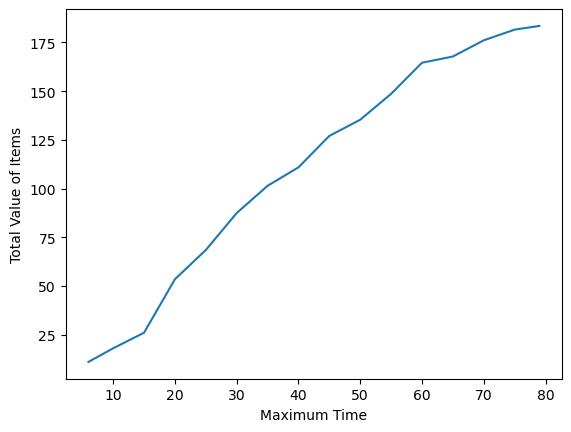

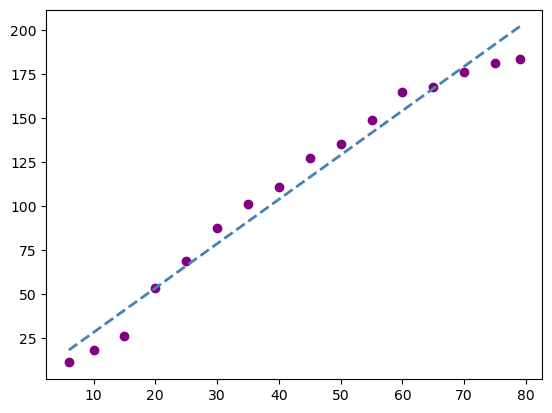

In [ ]:
plot()

In [ ]:
def part_eii(max_time):

    m = Model("Supermarket Sweep")

    x = {}
    z = {}

    # x variables
    for i in range(0, 57):
        for j in range(1, 58):
            x[i, j] = m.addVar(vtype = GRB.BINARY, name = f'x_{i}_{j}')

    # z variables
    for i in range(1, 57):
        z[i] = m.addVar(vtype = GRB.BINARY, name = f'z_{i}')

    m.addConstr(x[0, 57] == 0)
    m.addConstr(x[0, 57] == 0)

    # Identity constraint
    for i in range(0, 57):
        for j in range(1, 58):
            if (i >= j):
                m.addConstr(x[i, j] == 0)

    # 10 items max for each shopper
    m.addConstr(quicksum(z[i] for i in range(1, 57)) <= 10)

    # 60 seconds max for each shopper
    m.addConstr((quicksum(shortest_item_to_item_dict[item_list[i], item_list[j]]*x[i, j] for i in range(0, 57) for j in range(1, 58))) + 2 * quicksum(z[i] for i in range(1, 57)) <= max_time)

    # Connectivity constraints between zik and xijk
    for j in range(1, 57):
        m.addConstr(quicksum(x[i, j] for i in range(0, 57)) == z[j])

    for i in range(1, 57):
        m.addConstr(quicksum(x[i, j] for j in range(1, 58)) == z[i])

    # Shopper must reach end node
    m.addConstr(quicksum(x[i, 57] for i in range(1, 57)) == 1)

    # Shopper must leave start node
    m.addConstr(quicksum(x[0, j] for j in range(1, 57)) == 1)

    # Objective function
    obj = quicksum(price_dict[item_list[i]] * z[i] for i in range(1, 57))

    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

    path_list = ["Start Node"]
    number_list = []

    # Display results
    if m.status == GRB.OPTIMAL:
        price2_list = []
        print("Optimal solution found with detailed individual shopping paths.")
        all_vars = m.getVars()
        values = m.getAttr("X", all_vars)
        names = m.getAttr("VarName", all_vars)

        for name, val in zip(names, values):
            if (val == 1 and name[0] == "z"):
                number = int(name[2:])
                number_list.append(number)
                path_list.append(item_list[number])
#             if (val == 1 and name[0] == "x"):
#                 print(name)

        path_list.append("End Node")
        print("\n")
        print("\n")
        print(path_list)
        for i in path_list:
            price2_list.append(price_dict[i])

        print("\n")
        print("Total value of items from shopper 1: $" + str(m.objVal))
    else:
        print("No optimal solution found.")

    return [number_list, m.objVal]

In [ ]:
alist = part_eii(60.0)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1714 rows, 3305 columns and 11510 nonzeros
Model fingerprint: 0x7f3f2b32
Variable types: 0 continuous, 3305 integer (3305 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Presolve removed 1600 rows and 1599 columns
Presolve time: 0.01s
Presolved: 114 rows, 1706 columns, 5098 nonzeros
Variable types: 0 continuous, 1706 integer (1706 binary)
Found heuristic solution: objective 12.9800000
Found heuristic solution: objective 36.1300000

Root relaxation: objective 1.026157e+02, 182 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  102.6157

In [ ]:
def eiv(max_time):

    m = Model("Supermarket Sweep")

    x = {}
    z = {}

    # x variables
    for i in range(0, 57):
        for j in range(1, 58):
            x[i, j] = m.addVar(vtype = GRB.BINARY, name = f'x_{i}_{j}')

    # z variables
    for i in range(1, 57):
        z[i] = m.addVar(vtype = GRB.BINARY, name = f'z_{i}')

    m.addConstr(x[0, 57] == 0)
    m.addConstr(x[0, 57] == 0)

    # Ensure no subtours
    for i in range(0, 57):
        for j in range(1, 58):
            if (i >= j):
                m.addConstr(x[i, j] == 0)

    # 10 items max for each shopper
    m.addConstr(quicksum(z[i] for i in range(1, 57)) <= 10)

    # 60 seconds max for each shopper
    m.addConstr((quicksum(shortest_item_to_item_dict[item_list[i], item_list[j]]*x[i, j] for i in range(0, 57) for j in range(1, 58))) <= max_time - 2 * quicksum(z[i] for i in range(1, 57)))

    # Connectivity constraints between zik and xijk
    for j in range(1, 57):
        m.addConstr(quicksum(x[i, j] for i in range(0, 57)) == z[j])

    for i in range(1, 57):
        m.addConstr(quicksum(x[i, j] for j in range(1, 58)) == z[i])
        m.addConstr(quicksum(x[i, j] for j in range(1, 58)) == z[i])

    # Shopper must reach end node
    m.addConstr(quicksum(x[i, 57] for i in range(1, 57)) == 1)

    # Shopper must leave start node
    m.addConstr(quicksum(x[0, j] for j in range(1, 57)) == 1)

    for i in alist[0]:
        m.addConstr(z[i] == 0)

    # Objective function
    obj = quicksum(price_dict[item_list[i]] * z[i] for i in range(1, 57))

    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

    path_list = ["Start Node"]

    # Display results
    if m.status == GRB.OPTIMAL:
        price3_list = []
        print("Optimal solution found with detailed individual shopping paths.")
        all_vars = m.getVars()
        values = m.getAttr("X", all_vars)
        names = m.getAttr("VarName", all_vars)

        for name, val in zip(names, values):
            if (val == 1 and name[0] == "z"):
                number = int(name[2:])
                path_list.append(item_list[number])
#             if (val == 1 and name[0] == "x"):
#                 print(name)

        path_list.append("End Node")

        print("\n")
        print("\n")
        print(path_list)
        for i in path_list:
            price3_list.append(price_dict[i])
        print("\n")
        print("Total value of items from both shopper 2: $" + str(m.objVal))
    else:
        print("No optimal solution.")

    return m.objVal

In [ ]:
optVal = eiv(60)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1780 rows, 3305 columns and 14768 nonzeros
Model fingerprint: 0x692d6ffc
Variable types: 0 continuous, 3305 integer (3305 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 5.4900000
Presolve removed 1686 rows and 2134 columns
Presolve time: 0.01s
Presolved: 94 rows, 1171 columns, 3494 nonzeros
Variable types: 0 continuous, 1171 integer (1171 binary)

Root relaxation: objective 5.914043e+01, 131 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   59.14043    0   20    5.49000   59.14043   977%     -   

In [ ]:
total = optVal + alist[1]
print("Total value of items from both shoppers: $", total)

Total value of items from both shoppers: $ 155.81


In [ ]:
def debugging(bolist):
    price_list = []
    time_l = []
    for i in bolist:
        price_list.append(price_dict[i])

    for i in range(0, len(bolist)-1):
        time_l.append(shortest_item_to_item_dict[bolist[i], bolist[i+1]])

    print(price_list)
    print(time_l)
    print(sum(price_list))
    print(sum(time_l)+2*(len(bolist)-2))

    return

In [ ]:
debugging(['Start Node', 'Capt. Crunch', 'Granola', 'Tootpaste', 'Shampoo', 'Trash Bags', 'Oreos', 'Gatorade (12)', 'Redbull (4)', 'Ritz', 'End Node'])

[0.0, 3.99, 5.49, 3.99, 8.99, 8.99, 3.99, 6.99, 7.99, 3.99, 0.0]
[6.5, 3.5, 6.5, 0.5, 3.5, 6.0, 5.0, 0.5, 1.5, 8.5]
54.41000000000001
60.0
